### В качестве проекта, возьмем датасет 'Amazon Fine Food Reviews' с сайта kaggle.com. В данном датасете представлено 568454 отзыва о различных продуктах с сайта Amazon. Попробуем предсказать оценку продукта, на основе отзывов.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk
import os

In [2]:
reviews = pd.read_csv('Reviews.csv')

In [3]:
reviews.columns

Index([u'Id', u'ProductId', u'UserId', u'ProfileName', u'HelpfulnessNumerator',
       u'HelpfulnessDenominator', u'Score', u'Time', u'Summary', u'Text'],
      dtype='object')

In [4]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Оставим только столбцы Score и Text.

In [5]:
reviews = reviews[['Score', 'Text']]

In [6]:
reviews.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [7]:
reviews.shape

(568454, 2)

### Возьмем из нашей выборки все отзывы, при этом отсеим стоп слова с помощью библиотеки nltk.

In [8]:
from sklearn.feature_extraction import text

In [9]:
amazon_text = reviews['Text'].values

Избавимся от всех символов, кроме букв английского алфавита и цифр.

In [10]:
for T in range(len(amazon_text)):
    amazon_text[T] = re.sub(r"[^A-Za-z0-9]", " ", amazon_text[T])
    amazon_text[T] = ' '.join([word for word in amazon_text[T].lower().split() if word not in set(text.ENGLISH_STOP_WORDS)])

### Попробуем использовать оба подхода нормализации слов: стемминг и лемматизацию. Позже сравним результаты.

In [11]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

In [12]:
st = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [13]:
Stemmed_amazon_text = []
Lemmatized_amazon_text = []

In [14]:
%%time

for i in range(len(amazon_text)):
    Stemmed_text = []
    for j in amazon_text[i].split():
        try:
            Stemmed_text.append(st.stem(j))
        except:
            Stemmed_text.append[j]
    Stemmed_text = ' '.join(Stemmed_text)
    Stemmed_amazon_text.append(Stemmed_text)

Wall time: 10min 42s


In [15]:
%%time 

for i in range(len(amazon_text)):
    Lemmatized_text = []
    for j in amazon_text[i].split():
        try:
            Lemmatized_text.append(wordnet_lemmatizer.lemmatize(j))
        except:
            Lemmatized_text.append[j]
    Lemmatized_text = ' '.join(Lemmatized_text)
    Lemmatized_amazon_text.append(Lemmatized_text)

Wall time: 2min 38s


### Сохраним датасет.

In [16]:
reviews['Stemmed'] = Stemmed_amazon_text
reviews['Lemmatized'] = Lemmatized_amazon_text
reviews['Text'] = amazon_text

In [17]:
reviews.to_csv('preprocessed_reviews.csv', sep=',', index=None, header=True)

In [18]:
reviews.head()

,Score,Text,Stemmed,Lemmatized
0,5,bought vitality canned dog food products good ...,bought vit can dog food produc good qual produ...,bought vitality canned dog food product good q...
1,1,product arrived labeled jumbo salted peanuts p...,produc ar label jumbo salt peanut peanut act s...,product arrived labeled jumbo salted peanut pe...
2,4,confection centuries light pillowy citrus gela...,confect century light pillowy citr gelatin nut...,confection century light pillowy citrus gelati...
3,2,looking secret ingredient robitussin believe g...,look secret ingredy robitussin believ got addi...,looking secret ingredient robitussin believe g...
4,5,great taffy great price wide assortment yummy ...,gre taffy gre pric wid assort yummy taffy deli...,great taffy great price wide assortment yummy ...


### Изучим выборку подробнее. Будем исследовать лемматизированные тексты. После этого проделаем аналогичные действия для стеммированных текстов.

In [19]:
reviews.describe()

,Score
count,568454.000000
mean,4.183199
std,1.310436
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [20]:
reviews['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

### Доли оценок продуктов в выборке.

In [21]:
for i in range(1, 6):
    print('Доля объектов с рейтингом {} составляет {}%'.format(i, float(reviews['Score'].value_counts()[i]) / len(reviews) * 100))

Доля объектов с рейтингом 1 составляет 9.19476334057%
Доля объектов с рейтингом 2 составляет 5.2368353464%
Доля объектов с рейтингом 3 составляет 7.50104669859%
Доля объектов с рейтингом 4 составляет 14.188483149%
Доля объектов с рейтингом 5 составляет 63.8788714654%


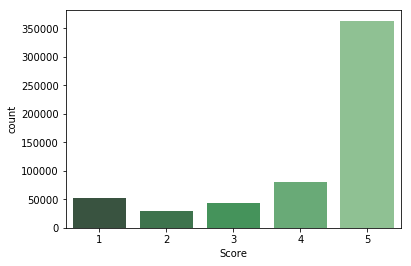

In [22]:
sns.countplot(x='Score', data=reviews, palette='Greens_d')
plt.show()

### Выборка не сбалансированна. Баланс классов сильно смещен в сторону класса с оценкой продукта, равной 5. Нужно построить модель, доля правильных ответов которой будет превышать долю наибольшего класса в выборке, т.е. ожидаемая точность модели не должна быть меньше 63%.

### Посмотрим на самые популярные слова в выборке

In [23]:
def get_popular_words(data):
    all_data = []
    for i in range(len(data)):
        all_data.extend(data[i].split())
    counter = Counter(all_data)
    return counter.most_common()

In [24]:
lemm_pop_words = get_popular_words(Lemmatized_amazon_text)

In [25]:
lemm_pop_words[:20]

[(u'br', 647116),
 (u's', 303385),
 (u't', 301972),
 (u'like', 267989),
 (u'taste', 218478),
 (u'good', 202411),
 (u'product', 200192),
 ('flavor', 187632),
 (u'coffee', 176327),
 (u'just', 172972),
 ('great', 167191),
 (u'love', 164014),
 (u'tea', 153862),
 (u'food', 153384),
 (u'make', 107891),
 (u'dog', 107704),
 (u'amazon', 106608),
 (u'time', 101639),
 (u'really', 101076),
 (u'don', 91874)]

### В связи с тем, что наша выборка довольно большая и в связи с ограниченностью вычислительных ресурсов, мы не будем использовать кросс-валидацию для оценки качества моделей и не будем выполнять полный подбор параметров для построения более качественной модели. Разобьём выборку на обучающую, тестовую и проверочную.

In [26]:
X_train, X_valid, Y_train, Y_valid = train_test_split(reviews['Lemmatized'], reviews['Score'],
                                                      test_size=0.2, random_state=1, stratify=reviews['Score'], shuffle=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train,
                                                    test_size=0.2, random_state=1, stratify=Y_train, shuffle=True)

### Построение моделей

In [27]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline

C:\Users\Eugeniy\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
predictions = []

In [39]:
%%time

c = 0
for model in [LogisticRegression, LinearSVC]:
    for vectorizer in [CountVectorizer, TfidfVectorizer]:
        for m_df in [1, 2]:
            model_vect = vectorizer(min_df=m_df)
            X = model_vect.fit_transform(X_train)
            X_t = model_vect.transform(X_test)
            X_v = model_vect.transform(X_valid)
            if c < 2:
                print('Количество признаков при min_df={}: {}'.format(m_df, X.shape[1]))
                c += 1
            linear_model = model()
            linear_model.fit(X, Y_train)
            predictions.append(('{} + {} + {}'.format(linear_model.__class__.__name__, model_vect.__class__.__name__,
                                            m_df), linear_model.predict(X_t), linear_model.predict(X_v), linear_model.coef_))

Количество признаков при min_df=1: 91623
Количество признаков при min_df=2: 51213
Wall time: 52min 49s


### Анализ полученных результатов предсказаний.

In [40]:
res_df = pd.DataFrame(predictions, columns=['model', 'test_predictions', 'valid_predictions', 'model_coeffs'])

In [41]:
res_df

,model,test_predictions,valid_predictions,model_coeffs
0,LogisticRegression + CountVectorizer + 1,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 4, 5, 5, 3, 5, 5, 4, 5, 4, 5, 5, 4, 5, 5, ...","[[0.32371485845419845, 0.1416539342310432, -0...."
1,LogisticRegression + CountVectorizer + 2,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 4, 5, 5, 3, 5, 5, 4, 5, 4, 5, 5, 4, 5, 5, ...","[[0.3222382369269091, 0.14380228287673522, -0...."
2,LogisticRegression + TfidfVectorizer + 1,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, ...","[[1.6282019737732405, -0.041612706611216084, -..."
3,LogisticRegression + TfidfVectorizer + 2,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, ...","[[1.619991034658271, -0.05399094747511653, -0...."
4,LinearSVC + CountVectorizer + 1,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 4, 5, 5, 3, 5, 5, 4, 5, 2, 5, 5, 4, 5, 5, ...","[[0.15426353522605796, 0.06574203469658318, -0..."
5,LinearSVC + CountVectorizer + 2,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 4, 5, 5, 3, 5, 5, 4, 5, 2, 5, 5, 4, 5, 5, ...","[[0.14222375912684154, 0.09077960863263419, -0..."
6,LinearSVC + TfidfVectorizer + 1,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, ...","[[0.5504454678848048, 0.04489240922189044, -0...."
7,LinearSVC + TfidfVectorizer + 2,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 2, 5, 5, 4, 5, 5, ...","[[0.545705929491729, 0.03999785055110664, -0.4..."


In [42]:
target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5']

In [43]:
res_df['test_acc'] = [metrics.accuracy_score(Y_test, pred) for pred in res_df.test_predictions]
res_df['valid_acc'] = [metrics.accuracy_score(Y_valid, pred) for pred in res_df.valid_predictions]
res_df['test_report'] = [metrics.classification_report(Y_test, pred, target_names=target_names) for pred in res_df.test_predictions]
res_df['valid_report'] = [metrics.classification_report(Y_valid, pred, target_names=target_names) for pred in res_df.valid_predictions]

In [44]:
res_df.sort_values(by='valid_acc', ascending=False, inplace=True)

In [45]:
res_df

,model,test_predictions,valid_predictions,model_coeffs,test_acc,valid_acc,test_report,valid_report
6,LinearSVC + TfidfVectorizer + 1,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, ...","[[0.5504454678848048, 0.04489240922189044, -0....",0.752103,0.753490,precision recall f1-score s...,precision recall f1-score s...
7,LinearSVC + TfidfVectorizer + 2,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 2, 5, 5, 4, 5, 5, ...","[[0.545705929491729, 0.03999785055110664, -0.4...",0.750695,0.751977,precision recall f1-score s...,precision recall f1-score s...
4,LinearSVC + CountVectorizer + 1,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 4, 5, 5, 3, 5, 5, 4, 5, 2, 5, 5, 4, 5, 5, ...","[[0.15426353522605796, 0.06574203469658318, -0...",0.748595,0.748687,precision recall f1-score s...,precision recall f1-score s...
5,LinearSVC + CountVectorizer + 2,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 4, 5, 5, 3, 5, 5, 4, 5, 2, 5, 5, 4, 5, 5, ...","[[0.14222375912684154, 0.09077960863263419, -0...",0.746385,0.747095,precision recall f1-score s...,precision recall f1-score s...
0,LogisticRegression + CountVectorizer + 1,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 4, 5, 5, 3, 5, 5, 4, 5, 4, 5, 5, 4, 5, 5, ...","[[0.32371485845419845, 0.1416539342310432, -0....",0.747122,0.746673,precision recall f1-score s...,precision recall f1-score s...
1,LogisticRegression + CountVectorizer + 2,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 4, 5, 5, 3, 5, 5, 4, 5, 4, 5, 5, 4, 5, 5, ...","[[0.3222382369269091, 0.14380228287673522, -0....",0.746473,0.745864,precision recall f1-score s...,precision recall f1-score s...
2,LogisticRegression + TfidfVectorizer + 1,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, ...","[[1.6282019737732405, -0.041612706611216084, -...",0.735655,0.737402,precision recall f1-score s...,precision recall f1-score s...
3,LogisticRegression + TfidfVectorizer + 2,"[1, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 3, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, ...","[[1.619991034658271, -0.05399094747511653, -0....",0.735501,0.737385,precision recall f1-score s...,precision recall f1-score s...


### Доли правильных ответов на тестовой и на проверочной выборках очень близки. Это свидетельствует об отсутствии переобучения. Далее будем рассматривать только лучшую модель, т.е. LinearSVC с использованием Tfidf и параметром min_df = 1.

### Посмотрим на гистограммы распределений.

### Истинные значения для выборки (для обучающей/тестовой/проверочной выборок распределение одинаковое, т.к. мы совершали разбиение на обучение, тест и проверку с сохранением баланса классов).

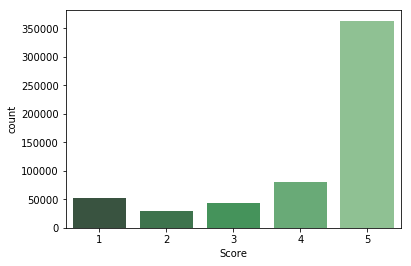

In [46]:
sns.countplot(x='Score', data=reviews, palette='Greens_d')
plt.show()

### Предсказанные значения для тестовой выборки.

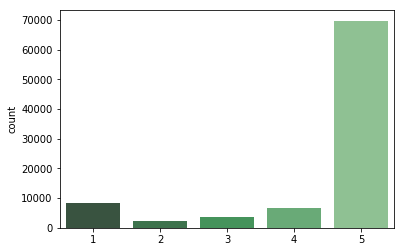

In [47]:
sns.countplot(res_df.test_predictions.values[0], palette='Greens_d')
plt.show()

In [48]:
print 'True labels:', sorted(Counter(Y_test).items())
print 'Predicted labels:', sorted(Counter(res_df.test_predictions.values[0]).items())

True labels: [(1L, 8363), (2L, 4763), (3L, 6822), (4L, 12905), (5L, 58100)]
Predicted labels: [(1, 8426), (2, 2341), (3, 3706), (4, 6682), (5, 69798)]


### Предсказанные значения для проверочной выборки.

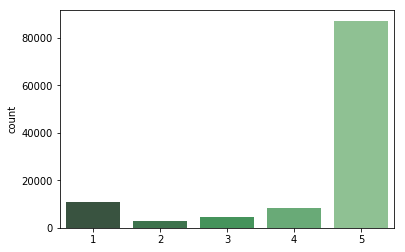

In [49]:
sns.countplot(res_df.valid_predictions.values[0], palette='Greens_d')
plt.show()

In [50]:
print 'True labels:', sorted(Counter(Y_valid).items())
print 'Predicted labels:', sorted(Counter(res_df.valid_predictions.values[0]).items())

True labels: [(1L, 10454), (2L, 5954), (3L, 8528), (4L, 16131), (5L, 72624)]
Predicted labels: [(1, 10784), (2, 2809), (3, 4640), (4, 8266), (5, 87192)]


In [51]:
test_labels_df = pd.DataFrame()
test_labels_df['test_true'] = Y_test
test_labels_df['test_predict'] = res_df.test_predictions.values[0]

In [52]:
valid_labels_df = pd.DataFrame()
valid_labels_df['valid_true'] = Y_valid
valid_labels_df['valid_predict'] = res_df.valid_predictions.values[0]

In [53]:
test_labels_df.describe()

,test_true,test_predict
count,90953.000000,90953.000000
mean,4.183205,4.397260
std,1.310443,1.259794
min,1.000000,1.000000
25%,4.000000,5.000000
50%,5.000000,5.000000
75%,5.000000,5.000000
max,5.000000,5.000000


In [54]:
valid_labels_df.describe()

,valid_true,valid_predict
count,113691.000000,113691.000000
mean,4.183181,4.392133
std,1.310455,1.267474
min,1.000000,1.000000
25%,4.000000,5.000000
50%,5.000000,5.000000
75%,5.000000,5.000000
max,5.000000,5.000000


In [55]:
print(res_df.test_report.values[0])

             precision    recall  f1-score   support

    class 1       0.69      0.69      0.69      8363
    class 2       0.57      0.28      0.38      4763
    class 3       0.56      0.30      0.39      6822
    class 4       0.55      0.28      0.37     12905
    class 5       0.80      0.96      0.87     58100

avg / total       0.72      0.75      0.72     90953



### Для 2, 3, 4 классов значения метрик значительно ниже, чем для 1 и 5 классов. Это свидетельствует о том, что модель плохо справляется с классификацией этих объектов. Только примерно 55% объектов этих классов оказываются предсказанны правильно и это составляет только треть от общего количества объектов этих классов.

### Посмотрим на самые популярные слова, полученные в лучшей модели.

In [56]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(X_train)

X_t = tfidf_vectorizer.transform(X_test)
X_v = tfidf_vectorizer.transform(X_valid)

In [57]:
%%time

linearsvc = LinearSVC()
linearsvc.fit(X, Y_train)

Wall time: 1min 4s


In [58]:
coeffs = linearsvc.coef_
top_words = []

In [59]:
for i in range(len(coeffs)):
    top_words.append((i + 1, [tfidf_vectorizer.get_feature_names()[list(coeffs[i]).index(j)] for j in sorted(coeffs[i], reverse=True)[:5]]))

In [60]:
top_words

[(1, [u'worst', u'limpest', u'putrid', u'worsen', u'splendia']),
 (2, [u'silvered', u'retard', u'ital', u'chewlotta', u'teai']),
 (3, [u'ideology', u'unfreshness', u'realllly', u'b003mwbfxy', u'vh']),
 (4, [u'flattens', u'b000zsx4d2', u'boodas', u'18cnt', u'realatively']),
 (5, [u'hahaha', u'lifespan', u'botts', u'loko', u'whimpy'])]

### Вернёмся к выборке, к которой мы применили стемминг.

In [61]:
stemmed_pop_words = get_popular_words(Stemmed_amazon_text)

In [62]:
stemmed_pop_words[:20]

[(u'br', 647112),
 (u's', 303326),
 (u't', 301927),
 (u'lik', 288933),
 (u'tast', 266155),
 (u'flav', 222289),
 (u'produc', 208517),
 (u'us', 206419),
 (u'good', 205357),
 ('lov', 193917),
 ('coff', 177272),
 ('just', 173989),
 ('gre', 169214),
 ('tea', 153904),
 (u'food', 153414),
 (u'mak', 134467),
 (u'real', 133430),
 ('eat', 119523),
 (u'pack', 108623),
 ('buy', 108460)]

### Разобьём выборку на обучающую, тестовую и проверочную.

In [63]:
X_train_stem, X_valid_stem, Y_train_stem, Y_valid_stem = train_test_split(reviews['Stemmed'], reviews['Score'],
                                                    test_size=0.2, random_state=1, stratify=reviews['Score'], shuffle=True)
X_train_stem, X_test_stem, Y_train_stem, Y_test_stem = train_test_split(X_train_stem, Y_train_stem,
                                                    test_size=0.2, random_state=1, stratify=Y_train_stem, shuffle=True)

### Построение модели.

In [64]:
stemmed_predictions = []

In [65]:
tfidf_vect = TfidfVectorizer()
X = tfidf_vect.fit_transform(X_train_stem)

In [66]:
X_t = tfidf_vect.transform(X_test_stem)
X_v = tfidf_vect.transform(X_valid_stem)

In [67]:
print('Количество признаков: {}'.format(X.shape[1]))

Количество признаков: 62405


In [68]:
%%time

linearsvc = LinearSVC()
linearsvc.fit(X, Y_train_stem)

Wall time: 1min 11s


In [69]:
stemmed_predictions.append(('{} + {} + {}'.format(linearsvc.__class__.__name__, tfidf_vect.__class__.__name__,
                                            1), linearsvc.predict(X_t), linearsvc.predict(X_v), linearsvc.coef_))

In [70]:
stemmed_res_df = pd.DataFrame(stemmed_predictions, columns=['model', 'test_predictions', 'valid_predictions', 'model_coeffs'])

In [71]:
stemmed_res_df

,model,test_predictions,valid_predictions,model_coeffs
0,LinearSVC + TfidfVectorizer + 1,"[1, 2, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 4, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, ...","[[0.5541851253713543, -0.07285589367324243, -0..."


In [72]:
stemmed_res_df['test_acc'] = [metrics.accuracy_score(Y_test_stem, pred) for pred in stemmed_res_df.test_predictions]
stemmed_res_df['valid_acc'] = [metrics.accuracy_score(Y_valid_stem, pred) for pred in stemmed_res_df.valid_predictions]
stemmed_res_df['test_report'] = [metrics.classification_report(Y_test_stem, pred, target_names=target_names) for pred in stemmed_res_df.test_predictions]
stemmed_res_df['valid_report'] = [metrics.classification_report(Y_valid_stem, pred, target_names=target_names) for pred in stemmed_res_df.valid_predictions]

In [73]:
stemmed_res_df

,model,test_predictions,valid_predictions,model_coeffs,test_acc,valid_acc,test_report,valid_report
0,LinearSVC + TfidfVectorizer + 1,"[1, 2, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 4, 5, ...","[1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, ...","[[0.5541851253713543, -0.07285589367324243, -0...",0.734643,0.737587,precision recall f1-score s...,precision recall f1-score s...


In [74]:
print(stemmed_res_df.test_report[0])

             precision    recall  f1-score   support

    class 1       0.65      0.67      0.66      8363
    class 2       0.54      0.20      0.30      4763
    class 3       0.52      0.24      0.33      6822
    class 4       0.51      0.23      0.31     12905
    class 5       0.78      0.96      0.86     58100

avg / total       0.70      0.73      0.69     90953



### Модель, использующая стемминг для нормализации слов показала более низкое качество по сравнению с моделью, использующей лемматизацию. Для дальнейших исследований будем использовать модель, использующую лемматизацию.

### Для того, чтобы модель не настраивалась на преобладающие классы, изменим значение весов классов. Назначим классам веса, обратно пропорциональные частотам классов во входных данных.

In [78]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(X_train)

X_t = tfidf_vectorizer.transform(X_test)
X_v = tfidf_vectorizer.transform(X_valid)

In [76]:
%%time

linearsvc = LinearSVC(class_weight='balanced')
linearsvc.fit(X, Y_train)

Wall time: 1min 29s


In [77]:
balanced_predictions = linearsvc.predict(X_t)

In [79]:
print(metrics.classification_report(Y_test, balanced_predictions, target_names=target_names))

             precision    recall  f1-score   support

    class 1       0.63      0.72      0.67      8363
    class 2       0.37      0.45      0.41      4763
    class 3       0.41      0.46      0.43      6822
    class 4       0.48      0.39      0.43     12905
    class 5       0.87      0.86      0.86     58100

avg / total       0.73      0.73      0.73     90953



In [80]:
print(metrics.accuracy_score(Y_test, balanced_predictions))

0.7272107572042703


In [81]:
print 'True labels:', sorted(Counter(Y_test).items())
print 'Predicted labels:', sorted(Counter(balanced_predictions).items())

True labels: [(1L, 8363), (2L, 4763), (3L, 6822), (4L, 12905), (5L, 58100)]
Predicted labels: [(1, 9517), (2, 5919), (3, 7648), (4, 10453), (5, 57416)]


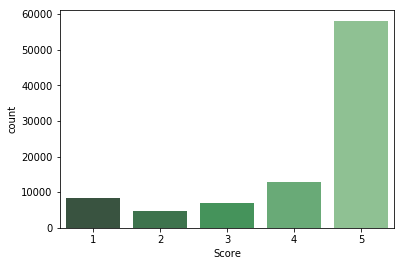

In [82]:
sns.countplot(Y_test, palette='Greens_d')
plt.show()

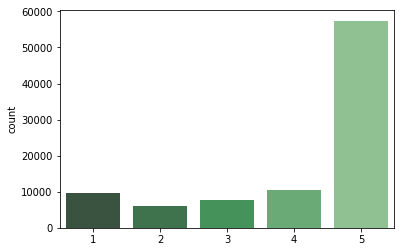

In [83]:
sns.countplot(balanced_predictions, palette='Greens_d')
plt.show()

### Доля правильных ответов уменьшилась, но при этом выросла полнота, уменьшилась точность на классах 2, 3, 4 и увеличилось значение F-меры на этих классах.

### Выводы:
### Мы построили линейные модели LogisticRegression и LinearSVC с использованием как CountVectorizer, так и с использованием TfidfVectorizer. Лучшего качества удалось достигнуть при использовании LinearSVC с TfidfVectorizer. Мы не столкнулись с проблемой переобучения. Доля правильных ответов составляет 75% на тестовой и на проверочной выборках. Это неплохой результат для многоклассовой классификации. Однако, в силу несбалансированности выборки, заметно преобладание 5-ого класса, что негативно сказалось на всей модели в целом, как видно из полученных результатов, модель слишком часто предсказывает 5-ый класс. Для борьбы с этим можно использовать oversampling, undersampling или корректировку весов классов. Корректировка весов классов позволила модели лучше различать объекты 2, 3, 4 классов, но accuracy упала. Для улучшения модели можно применить undersampling, дополнить словарь стоп-слов и воспользоваться токенизатором.